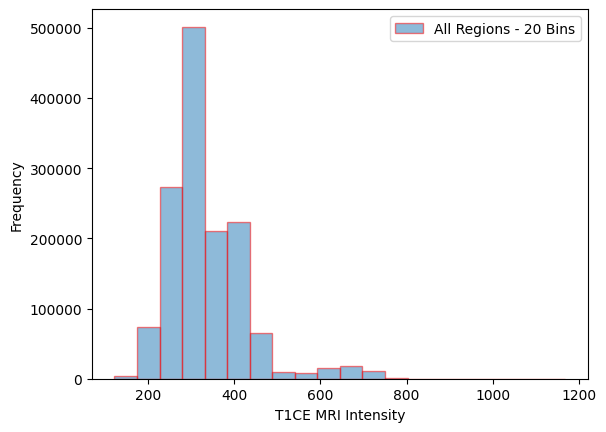

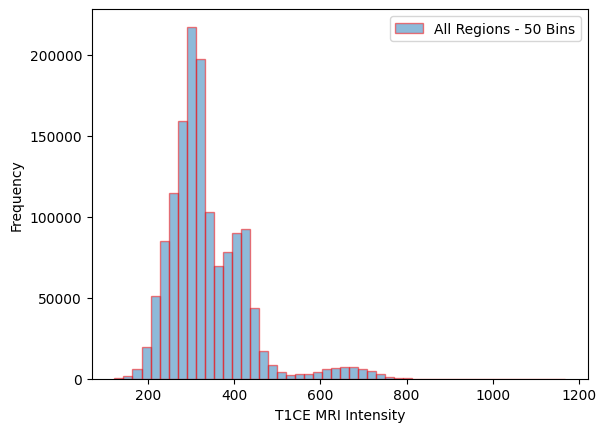

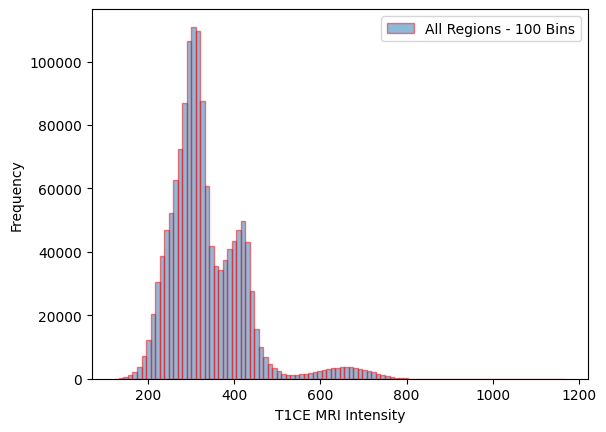

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import glob
import gzip
import shutil

# Directories for T1 and segmented images
baseline_dir = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Baseline/'
seg_dir = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Seg/'

# Getting all T1 .gz files
t1_gz_files = glob.glob(f"{baseline_dir}*t1ce*.gz")

# Initialize an empty list to hold all edema T1 values from all images
all_edema_t1_values = []

for t1_gz_file in t1_gz_files:
    t1_file = t1_gz_file[:-3]  # Expected .nii file name after extraction

    # If the .nii file does not exist, extract the .gz file
    if not os.path.exists(t1_file):
        with gzip.open(t1_gz_file, 'rb') as f_in:
            with open(t1_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

    # Constructing the segmented file path based on the T1 file name
    file_name_parts = os.path.basename(t1_file).split('_')
    segmented_file_name = f"{file_name_parts[0]}_{file_name_parts[1]}_LPS_rSRI_segmF.nii"
    segmented_file = os.path.join(seg_dir, segmented_file_name)

    # If the segmented .nii file does not exist, but the .gz does, extract it
    if not os.path.exists(segmented_file):
        segmented_gz_file = segmented_file + '.gz'
        if os.path.exists(segmented_gz_file):
            with gzip.open(segmented_gz_file, 'rb') as f_in:
                with open(segmented_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        else:
            print(f"Segmented file and gz for {segmented_file_name} not found.")
            continue

    try:
        # Load the T1 MRI and segmented image files
        t1_img = nib.load(t1_file)
        segmented_img = nib.load(segmented_file)

        # Get the data arrays from the loaded images
        t1_data = t1_img.get_fdata()
        segmented_data = segmented_img.get_fdata()

        # Extract the T1 MRI values within the edema region (label 2)
        edema_t1_values = t1_data[segmented_data == 2]
        all_edema_t1_values.extend(edema_t1_values)

    except (OSError, EOFError) as e:
        print(f"Error reading file {t1_file}: {e}")
        continue  # Skip to the next file

# Bin sizes
bin_sizes = [20, 50, 100]

for bin_size in bin_sizes:
    # Plot the histogram of T1 MRI for all images with the current bin size
    plt.hist(all_edema_t1_values, bins=bin_size, alpha=0.5, label=f'All Regions - {bin_size} Bins', edgecolor='red')

    # Add labels and legend to the histogram plot
    plt.xlabel('T1CE MRI Intensity')
    plt.ylabel('Frequency')
    plt.legend()

    # Show the histogram plot
    plt.show()

    # Clear the current plot to start fresh for the next bin size
    plt.clf()
